## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
plt.style.use('dark_background')

### Perceptual decision making

__1. Create a function for generating the data.__

In [2]:
# Defining constants given in the exercise description.
mu = 0
std = 0.03
stim_strengths = lambda batch_size: [3.2 / 100 * random.choice(np.array([1, 2, 4, 8, 16])) for i in range(batch_size)]

In [3]:
def get_input(u_bar, t_step, mu, std):
    u = np.zeros(t_step)
    for t in range(t_step):
        if 5 <= t <= 45:
            u[t] = u_bar + np.random.normal(mu, std)
        else:
            u[t] = np.random.normal(mu, std)
    
    return u

def generate_data(stim_strengths, t_step, mu, std):
    U = np.zeros((len(stim_strengths), t_step))
    y = np.zeros(len(stim_strengths))
    for trial, stim_strength in enumerate(range(len(stim_strengths))):
        u_bar = np.random.uniform(-stim_strengths[trial], stim_strengths[trial])
        U[trial] = get_input(u_bar, t_step, mu, std)
        y[trial] = np.sign(u_bar)
        
    return torch.from_numpy(U), torch.from_numpy(y)

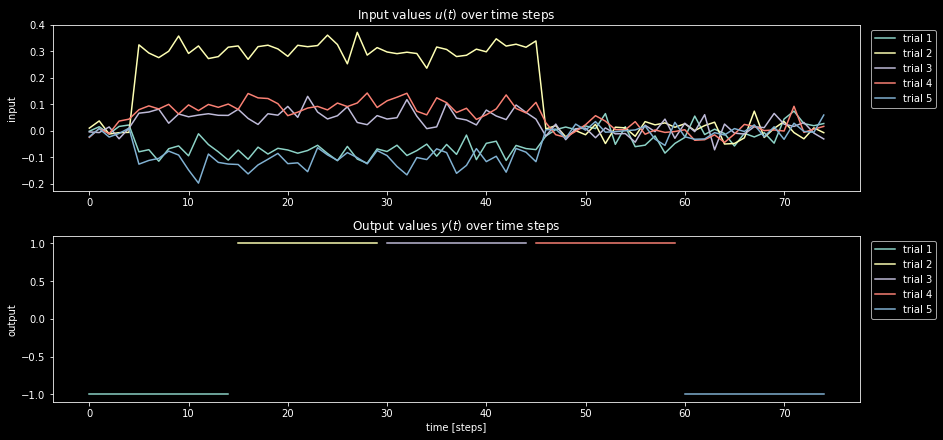

In [4]:
t_steps = 75
U, y = generate_data(stim_strengths(5), t_steps, mu, std)

fig, axs = plt.subplots(2, 1, figsize = (13, 6), constrained_layout = True)
for trial in range(U.shape[0]):
    axs[0].set_title(r'Input values $u(t)$ over time steps')
    axs[0].plot(np.arange(0, t_steps, 1), U[trial], label = f'trial {trial+1}')
    axs[0].set_ylabel('input')
    
    axs[1].set_title(r'Output values $y(t)$ over time steps')
    axs[1].plot(np.arange(trial * t_steps/U.shape[0], (trial+1) * t_steps/U.shape[0], 1), 
                np.full(int(t_steps/U.shape[0]), y[trial]), label = f'trial {trial+1}')
    axs[1].set_ylabel('output')
    axs[1].set_xlabel('time [steps]')

for i in range(2):
    axs[i].legend(loc = 'upper right', bbox_to_anchor = (1.1, 1))
plt.show()

__2. Implement the recurrent neural network in your favorite deep learning library.__

In [5]:
# Define the functions.
phi = lambda x: torch.tanh(x)
dynamics = lambda u, x, t, I, J, tau=0.1: (-x + torch.matmul(J, phi(x)) + I*u[t]) / tau
output = lambda x, N: 1 / N * w(N)@phi(x)

In [6]:
def forward_euler(u, x, t, I, J, dt=0.02, tau=0.1):
    x = x + dt * dynamics(u, x, t, I, J, tau)
    return x

In [7]:
class RNN(nn.Module):
    '''
    Single custom RNN layer with a low-rank connectivity matrix and a leak term.
    '''
    def __init__(self, input_size, hidden_size, rank):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.m_list = nn.ParameterList([nn.Parameter(torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)) for i in range(rank)])
        self.n_list = nn.ParameterList([nn.Parameter(torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)) for i in range(rank)])

    def forward(self, u, I, t, x):
        m_n = torch.zeros((128, 128))
        for i in range(len(self.m_list)):
            m_n += torch.matmul(self.m_list[i], self.n_list[i].T)
            
        J = 1 / self.hidden_size * m_n
        # J = 1 / self.hidden_size * torch.matmul(self.m, self.n.T)
        x = forward_euler(u, x, t, I, J)
        return x

In [8]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, rank=1):
        super(Model, self).__init__()
        
        # Define the number of layers and the nodes in each layer.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rank = rank
        
        # Define and initialize the fixed weights I and w.
        self.I = torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)
        self.w = torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)
        
        # Define the network layers.
        self.rnn = RNN(input_size, hidden_size, rank)
        
    def forward(self, u, t, x):
        x = self.rnn(u, self.I, t, x).reshape(self.hidden_size, self.input_size)
        z = 1 / self.hidden_size * torch.matmul(self.w.T, phi(x))
        
        return x, z

__3. Train a network of size $N = 128$ by minimizing the mean squared error using stochastic gradient descent.__

In [9]:
def train_network(model, U, y, input_size, hidden_size, t_steps, n_epochs=100, lr=5e-3, single_batch=False):
    batch_size = U.shape[0]
    time_steps = U.shape[1]
    n_last_steps = 15
    last_steps = t_steps - n_last_steps

    x = torch.normal(torch.zeros(hidden_size), torch.ones(hidden_size)).reshape(hidden_size, input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    if single_batch:
        batch_size = 1  # train the network on a single batch -> overfitting
        
    loss_log = np.zeros(n_epochs)
    x_log = np.zeros((n_epochs, batch_size, hidden_size))
    z_log = np.zeros((n_epochs, batch_size))
        
    for epoch in range(1, n_epochs+1):
        epoch_loss = 0
        for batch in range(batch_size):
            for t in range(t_steps):
                x, z = model(U[batch], t, x)
                
                # Minimize the loss function over the last 15 time steps.
                if t >= last_steps:
                    loss = (z - y[batch])**2
                    loss.backward()    # Compute the gradients
                    optimizer.step()   # Parameter updates
                                        
                    model.zero_grad()  # Clear the gradients
                    x = x.detach()  
                    
                    epoch_loss += loss
                    x_log[epoch-1, batch] = x.numpy().reshape(hidden_size)
                    z_log[epoch-1, batch] = z.detach().numpy()
                    
        loss_log[epoch-1] = epoch_loss / (n_last_steps * batch_size)
        if epoch%10 == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
            print("Loss: {:.4f}".format(loss_log[epoch-1]))
            
    return loss_log, x_log, z_log
# https://stackoverflow.com/questions/48274929/pytorch-runtimeerror-trying-to-backward-through-the-graph-a-second-time-but

In [10]:
# Generate the data.
N = 128
t_steps = 75
batch_size = 32

stim_strengths_rnn = stim_strengths(batch_size)
U, y = generate_data(stim_strengths_rnn, t_steps, mu, std)

In [11]:
# Define the model.
input_size = 1
hidden_size = N
rank = 2
model = Model(input_size, hidden_size, rank)
model

Model(
  (rnn): RNN(
    (m_list): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 128x1]
        (1): Parameter containing: [torch.FloatTensor of size 128x1]
    )
    (n_list): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 128x1]
        (1): Parameter containing: [torch.FloatTensor of size 128x1]
    )
  )
)

In [12]:
single_batch = True
n_epochs = 100
loss, x_log, z_log = train_network(model, U, y, input_size, hidden_size, t_steps, n_epochs=100, single_batch=True)

Epoch: 10/100............. Loss: 0.9996
Epoch: 20/100............. Loss: 0.9996
Epoch: 30/100............. Loss: 0.8367
Epoch: 40/100............. Loss: 0.0552
Epoch: 50/100............. Loss: 0.0278
Epoch: 60/100............. Loss: 0.0199
Epoch: 70/100............. Loss: 0.0175
Epoch: 80/100............. Loss: 0.0162
Epoch: 90/100............. Loss: 0.0154
Epoch: 100/100............. Loss: 0.0149


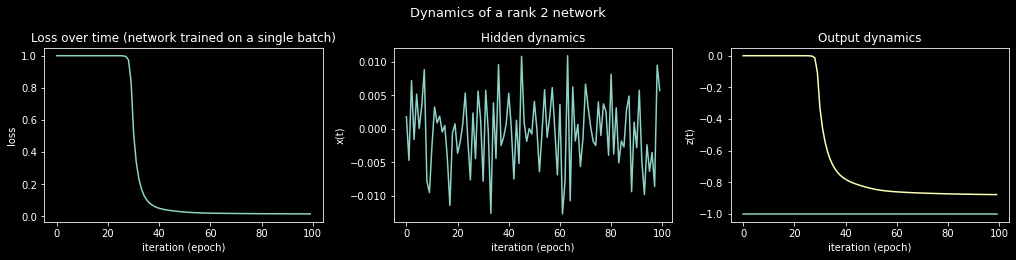

In [13]:
# Plot the loss, hidden and output dynamics.
plots = [loss.flatten(), x_log.reshape(128, 100)[0], np.full(n_epochs, y[0]), z_log]
titles = ['Loss over time', 'Hidden dynamics', 'Output dynamics']
y_labels = ['loss', 'x(t)', 'z(t)']

fig, axs = plt.subplots(1, 3, figsize = (14, 3.5), constrained_layout = True)
fig.suptitle(f'Dynamics of a rank {rank} network', fontsize = 13)
for i in range(3):
    axs[i].plot(plots[i])
    if i == 2:
        axs[i].plot(plots[3])
    if i == 0 and single_batch:
        axs[i].set_title('Loss over time (network trained on a single batch)')
    else:
        axs[i].set_title(titles[i])
    axs[i].set_xlabel('iteration (epoch)')
    axs[i].set_ylabel(y_labels[i])
plt.show()

__4. Dubreuil et al. found that their network relied on a specific pattern of correlations between the connectivity vectors (their figure 2b). Explain why this pattern works for the task, and compare it with the pattern in your network.__

TBD